<a href="https://colab.research.google.com/github/solobala/TSML13/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практика  к занятию «Нейронные сети в анализе временных рядов»

In [6]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
from google.colab import drive
from google.colab import files
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [8]:
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/TSML13_DZ1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
SERIES = Path(ROOT, 'Series')

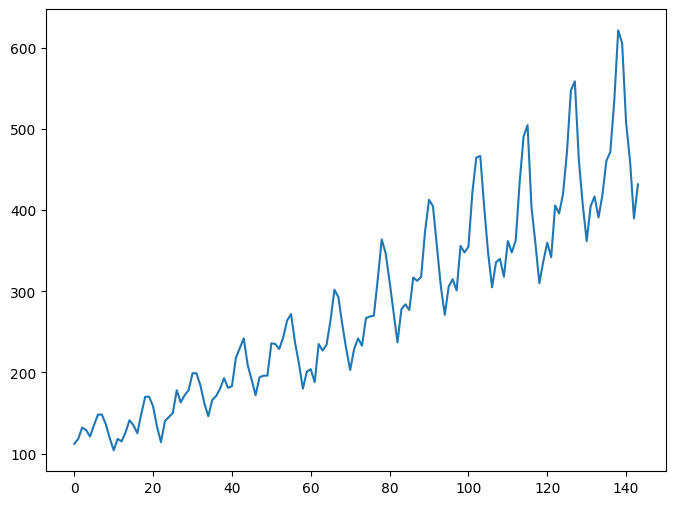

In [11]:
dataset = pd.read_csv(Path(SERIES, 'international-airline-passengers.csv'), usecols=[1], engine='python')

plt.figure(figsize=(8, 6))
plt.plot(dataset)
plt.show()

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [14]:
train[1:2, 0]

array([0.02702703])

In [15]:
# convert an array of values into a dataset matrix
# получается что как бы размерность добавили, что ли???
# ??? Что делает эта функция???
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    # диапазон меняется в зависимости от lookback, не захватываем 2 последних значения
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [16]:
# reshape into X=t and Y=t+1
# получается, X - текущее значение временного ряда, y- последующее
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
# reshape input to be [samples, time steps, features]
# ?? Что делает эта функция???
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
# create and fit the LSTM network
model = Sequential()
# Почему кол-во units=4? Чем руководствовались?
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 3s - loss: 0.0550 - 3s/epoch - 37ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0292 - 304ms/epoch - 3ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0215 - 283ms/epoch - 3ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0191 - 285ms/epoch - 3ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0179 - 287ms/epoch - 3ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0170 - 299ms/epoch - 3ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0162 - 255ms/epoch - 3ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0153 - 186ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0144 - 191ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0135 - 181ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0125 - 174ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0116 - 171ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0105 - 174ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0093 - 192ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0082 - 185ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0069 - 182ms/epoc

In [19]:
# make predictions - делаем прогнозы и на трейне, и на тесте
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
# У нас было выполнено масщтабирование ( нормалихзация), поэтому делаем invert_transform, чтобы ввернуться к реальным значениям
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 6ms/step
Train Score: 22.64 RMSE
Test Score: 50.43 RMSE


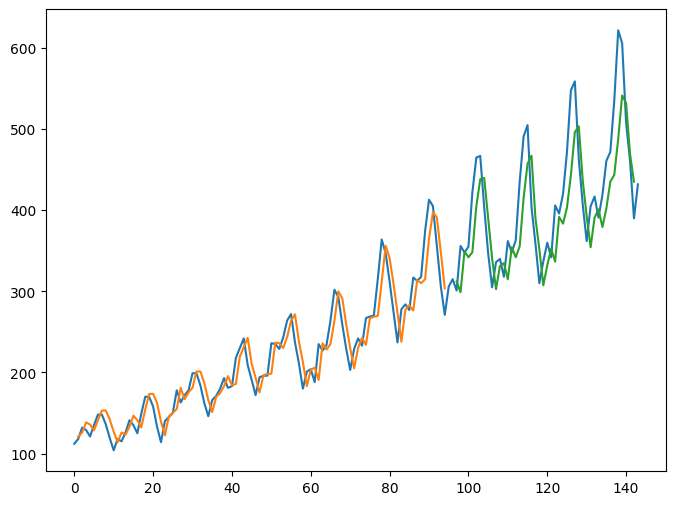

In [20]:
plt.figure(figsize=(8, 6))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()